## 2.2 Mining Cancer Feature Patterns

### Objective: 
#### The objective of this task is to analyse the feature sequences and patterns in cancer diagnosis data to uncover common characteristics that distinguish malignant from benign cases through sequential pattern mining.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools


In [2]:
# load dataset
df = pd.read_csv("data/Cancer_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

#### We observed 569 rows and 33 columns in the breast cancer dataset. In this task, we keep only the `id`, `diagnosis`, and all the `feature_mean` columns

In [3]:
df = df.drop(columns=df.columns[12:])
df.columns = df.columns.str.replace('_mean', '', regex=False)
features = [c for c in df.columns if c not in ["id", "diagnosis"]]
feature_df = df[features].copy()
df.head()

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


#### Before feature transformation to convert continuous features values to categorical representations `low`, `medium` or `high`, it is important to determine an appropriate statistical threshold for partitioning. We perfom a sensitivity analysis using KBinsDiscretizer across 3 strategies `uniform`, `quantile`, and `k-means` and compare how each strategy partition the features.

c:\Users\Jun Sheng\OneDrive\Desktop\project 2\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


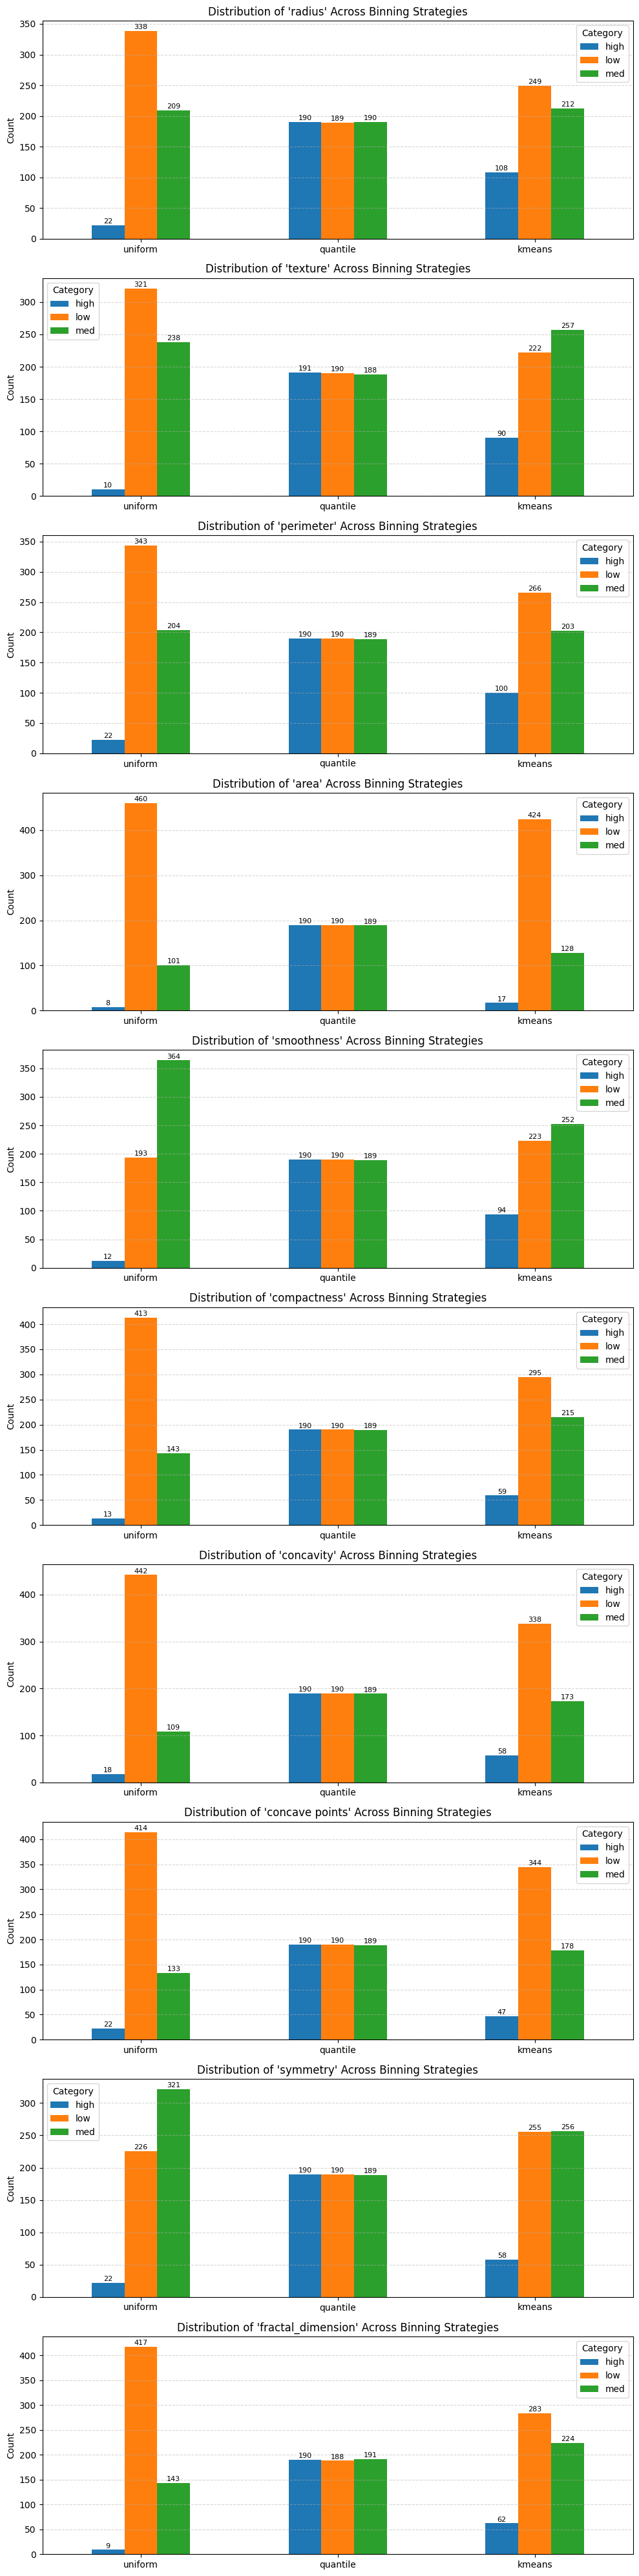

In [4]:
strategies = ['uniform', 'quantile', 'kmeans']

def summarize_bins(df, strategies):
    summaries = {}
    for s in strategies:
        disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy=s)
        bins = pd.DataFrame(disc.fit_transform(df), columns=df.columns)
        labels = bins.replace({0:'low',1:'med',2:'high'})
        summaries[s] = labels.apply(pd.Series.value_counts).fillna(0)
    return summaries

summaries = summarize_bins(feature_df, strategies)

# Visualize category Count distribution for each strategy
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 4*len(features)))
if len(features) == 1:
    axes = [axes]

for i, feature in enumerate(features):
    ax = axes[i]
    plot_df = pd.DataFrame({s: summaries[s][feature] for s in strategies}).fillna(0).T
    bars = plot_df.plot(kind='bar', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    # Add count labels on top of each bar
    for container_idx, container in enumerate(bars.containers):
        for bar_idx, rect in enumerate(container):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width()/2, height + 1,
                f"{int(height)}",
                ha='center', va='bottom', fontsize=8
            )

    ax.set_ylabel('Count')
    ax.set_title(f"Distribution of '{feature}' Across Binning Strategies")
    ax.legend(title='Category')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


#### From the comparative bar charts, we observed that the `uniform` binning divides the value range evenly but have imbalanced groupings when the data are skewed. `Quantile` binning balances the number of samples in each bin, making it suitable for unevenly distributed data. `K-means` binning groups data based on natural clusters, capturing the underlying structure effectively than uniform binning. However, `k-means` binning incurred higher computational cost due to its iterative clustering process.

### 1. Data Preprocessing

#### We convert continuous features values to categorical representations `low`, `medium`, `high` using KBinsDiscretizer (quantile).

In [5]:
# KBinsDiscretizer using quantile strategy
disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
X_binned = pd.DataFrame(disc.fit_transform(feature_df), columns=features)
X_cat = X_binned.replace({0: 'low', 1: 'med', 2: 'high'})
X_cat.head()

c:\Users\Jun Sheng\OneDrive\Desktop\project 2\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
0,high,low,high,high,high,high,high,high,high,high
1,high,med,high,high,low,med,med,high,med,low
2,high,high,high,high,high,high,high,high,high,med
3,low,med,low,low,high,high,high,high,high,high
4,high,low,high,high,med,high,high,high,med,low


#### To determine the relative importance of each feature for every patient, the z-score of each continuous feature was computed. The features were then ranked according to their z-scores in descending order, where higher z-scores indicate stronger deviations from the population mean and hence greater relative importance.

In [6]:
# Compute z-score
scaler = StandardScaler()
zscore_df = pd.DataFrame(scaler.fit_transform(feature_df), columns=features)

# Display the Z-score DataFrame
print("Feature Z-scores per patient:")
zscore_df.head(10) 

Feature Z-scores per patient:


,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450
5,-0.476375,-0.835335,-0.387148,-0.505650,2.237421,1.244335,0.866302,0.824656,1.005402,1.890005
6,1.170908,0.160649,1.138125,1.095295,-0.123136,0.088295,0.300072,0.646935,-0.064325,-0.762332
7,-0.118517,0.358450,-0.072867,-0.218965,1.604049,1.140102,0.061026,0.281950,1.403355,1.660353
8,-0.320167,0.588830,-0.184080,-0.384207,2.201839,1.684010,1.219096,1.150692,1.965600,1.572462
9,-0.473535,1.105439,-0.329482,-0.509063,1.582699,2.563358,1.738872,0.941760,0.797298,2.783096


In [7]:
rank_records = []

for i, row in zscore_df.iterrows():
    id = df.loc[i, "id"]
    diag = "Malignant" if df.loc[i, "diagnosis"] == "M" else "Benign"

    # Sort features by absolute z-score descending
    ranked_feats = row.abs().sort_values(ascending=False)
    feat_names = list(ranked_feats.index)
    z_values = [round(v, 3) for v in ranked_feats.values]

    # Get corresponding categorical level for each feature
    labels = [f"{X_cat.loc[i, f]}_{f}" for f in feat_names]

    rank_records.append({
        "id": id,
        "diagnosis": diag,
        "features": labels,
        "zscore_values": z_values
    })

# Display the ranking DataFrame 
rank_df = pd.DataFrame(rank_records)
pd.set_option('display.max_colwidth', None)
print("Features Ranking per Patient (ordered by |z-score|):")
rank_df.head(10)


Features Ranking per Patient (ordered by |z-score|):


,id,diagnosis,features,zscore_values
0,842302,Malignant,"[high_compactness, high_concavity, high_concave points, high_fractal_dimension, high_symmetry, low_texture, high_smoothness, high_perimeter, high_radius, high_area]","[3.284, 2.653, 2.532, 2.256, 2.218, 2.073, 1.568, 1.27, 1.097, 0.984]"
1,842517,Malignant,"[high_area, high_radius, high_perimeter, low_fractal_dimension, low_smoothness, high_concave points, med_compactness, med_texture, med_concavity, med_symmetry]","[1.909, 1.83, 1.686, 0.869, 0.827, 0.548, 0.487, 0.354, 0.024, 0.001]"
2,84300903,Malignant,"[high_concave points, high_radius, high_perimeter, high_area, high_concavity, high_compactness, high_smoothness, high_symmetry, high_texture, med_fractal_dimension]","[2.037, 1.58, 1.567, 1.559, 1.363, 1.053, 0.942, 0.94, 0.456, 0.398]"
3,84348301,Malignant,"[high_fractal_dimension, high_compactness, high_smoothness, high_symmetry, high_concavity, high_concave points, low_radius, low_area, low_perimeter, med_texture]","[4.911, 3.403, 3.284, 2.867, 1.916, 1.452, 0.769, 0.764, 0.593, 0.254]"
4,84358402,Malignant,"[high_area, high_perimeter, high_radius, high_concave points, high_concavity, low_texture, low_fractal_dimension, high_compactness, med_smoothness, med_symmetry]","[1.826, 1.777, 1.75, 1.428, 1.371, 1.152, 0.562, 0.539, 0.28, 0.01]"
5,843786,Malignant,"[high_smoothness, high_fractal_dimension, high_compactness, high_symmetry, high_concavity, low_texture, high_concave points, med_area, med_radius, med_perimeter]","[2.237, 1.89, 1.244, 1.005, 0.866, 0.835, 0.825, 0.506, 0.476, 0.387]"
6,844359,Malignant,"[high_radius, high_perimeter, high_area, low_fractal_dimension, high_concave points, high_concavity, med_texture, med_smoothness, med_compactness, med_symmetry]","[1.171, 1.138, 1.095, 0.762, 0.647, 0.3, 0.161, 0.123, 0.088, 0.064]"
7,84458202,Malignant,"[high_fractal_dimension, high_smoothness, high_symmetry, high_compactness, high_texture, high_concave points, med_area, med_radius, med_perimeter, med_concavity]","[1.66, 1.604, 1.403, 1.14, 0.358, 0.282, 0.219, 0.119, 0.073, 0.061]"
8,844981,Malignant,"[high_smoothness, high_symmetry, high_compactness, high_fractal_dimension, high_concavity, high_concave points, high_texture, med_area, med_radius, med_perimeter]","[2.202, 1.966, 1.684, 1.572, 1.219, 1.151, 0.589, 0.384, 0.32, 0.184]"
9,84501001,Malignant,"[high_fractal_dimension, high_compactness, high_concavity, high_smoothness, high_texture, high_concave points, high_symmetry, med_area, med_radius, med_perimeter]","[2.783, 2.563, 1.739, 1.583, 1.105, 0.942, 0.797, 0.509, 0.474, 0.329]"


#### Mutual information measures how much knowing a feature reduces uncertainty about the target variable. A higher MI score indicates that the feature provides more information relevant to predicting the diagnosis outcome. From the results, `concave points`, `perimeter`, `concavity`, `radius`, and `area` show high mutual information, suggesting that these features are the most influential in distinguishing malignant from benign cases.

In [8]:
# Mutual information ranking
mi_scores = pd.Series(mutual_info_classif(zscore_df, df['diagnosis']), index=features)
mi_scores = mi_scores.sort_values(ascending=False)
print("Features Ranking by Mutual Information:")
mi_scores

Features Ranking by Mutual Information:


concave points       0.438426
perimeter            0.402445
concavity            0.372499
radius               0.366732
area                 0.358654
compactness          0.212266
texture              0.093079
smoothness           0.087490
symmetry             0.063338
fractal_dimension    0.008426
dtype: float64

#### Group the top-k features as ordered itemsets with max sequence length L and max gap = 1 for every patient.

In [9]:
top_k = 10 # top-k ranked features per patient
threshold = 0.2 # grouping threshold for z-score similarity
L = 4 # maximum sequence length

sequences = []

for idx, row in rank_df.iterrows():
    pid = row["id"]
    diag = row["diagnosis"]

    # Select top-k features and z-scores 
    feats = row["features"][:top_k] 
    zscores = row["zscore_values"][:top_k]

    # Group by z-score closeness. same-order ties (|Δz| ≤ threshold) form one itemset {…}
    grouped = [[feats[0]]]
    for j in range(1, len(feats)):
        if abs(zscores[j-1] - zscores[j]) <= threshold:
            grouped[-1].append(feats[j])
        else:
            grouped.append([feats[j]])

    # Ensure max sequence length of 4 (L = 4)
    if len(grouped) > L:
        grouped = grouped[:L]

    # Build sequence string (max gap = 1)
    seq_str = "<" + ", ".join("{" + ", ".join(g) + "}" for g in grouped) + ">"

    sequences.append({
        "id": pid,
        "diagnosis": diag,
        "sequence": seq_str,
        "sequence_length": len(grouped)
    })

# Display sequence DataFrame
seq_df = pd.DataFrame(sequences)
print("Ordered itemsets with max sequence length 4:")
seq_df_styled = (seq_df.head(10).style.set_properties(**{'text-align': 'left'})) # Left-align 
seq_df_styled

Ordered itemsets with max sequence length 4:


,id,diagnosis,sequence,sequence_length
0,842302,Malignant,"<{high_compactness}, {high_concavity, high_concave points}, {high_fractal_dimension, high_symmetry, low_texture}, {high_smoothness}>",4
1,842517,Malignant,"<{high_area, high_radius, high_perimeter}, {low_fractal_dimension, low_smoothness}, {high_concave points, med_compactness, med_texture}, {med_concavity, med_symmetry}>",4
2,84300903,Malignant,"<{high_concave points}, {high_radius, high_perimeter, high_area, high_concavity}, {high_compactness, high_smoothness, high_symmetry}, {high_texture, med_fractal_dimension}>",4
3,84348301,Malignant,"<{high_fractal_dimension}, {high_compactness, high_smoothness}, {high_symmetry}, {high_concavity}>",4
4,84358402,Malignant,"<{high_area, high_perimeter, high_radius}, {high_concave points, high_concavity}, {low_texture}, {low_fractal_dimension, high_compactness}>",4
5,843786,Malignant,"<{high_smoothness}, {high_fractal_dimension}, {high_compactness}, {high_symmetry, high_concavity, low_texture, high_concave points}>",4
6,844359,Malignant,"<{high_radius, high_perimeter, high_area}, {low_fractal_dimension, high_concave points}, {high_concavity, med_texture, med_smoothness, med_compactness, med_symmetry}>",3
7,84458202,Malignant,"<{high_fractal_dimension, high_smoothness}, {high_symmetry}, {high_compactness}, {high_texture, high_concave points, med_area, med_radius, med_perimeter, med_concavity}>",4
8,844981,Malignant,"<{high_smoothness}, {high_symmetry}, {high_compactness, high_fractal_dimension}, {high_concavity, high_concave points}>",4
9,84501001,Malignant,"<{high_fractal_dimension}, {high_compactness}, {high_concavity, high_smoothness}, {high_texture, high_concave points, high_symmetry}>",4


### 2. Data Analysis: 

#### Apply sequential pattern mining algorithms (Generalized Sequential Pattern algorithm) to discover patterns in how cancer features manifest in malignant and benign cases. 

In [10]:
# Parse "<{a, b}, {c}>" into [["a","b"], ["c"]]
def parse_sequence(seq_str):
    s = seq_str.strip("<>")
    blocks = [b.replace("{","").replace("}","").strip() for b in s.split("},")]
    return [[t.strip() for t in b.split(",") if t.strip()] for b in blocks if b]

# GSP functions
def is_subsequence(candidate, sequence):
    i = 0
    for cand_set in candidate:
        found = False
        while i < len(sequence):
            if set(cand_set).issubset(sequence[i]):
                found = True
                i += 1
                break
            i += 1
        if not found: 
            return False
    return True

def frequent_1_sequences(sequences, min_sup):
    counts = defaultdict(int)
    for seq in sequences:
        # unique items per sequence for 1-seq counting
        for item in set(itertools.chain.from_iterable(seq)):
            counts[((item,),)] += 1
    return {k:v for k,v in counts.items() if v >= min_sup}

def generate_candidates(freq_k_minus_1):
    keys = list(freq_k_minus_1.keys())
    cands = set()
    for s1 in keys:
        for s2 in keys:
            if s1[1:] == s2[:-1]:                   
                cands.add(s1 + (s2[-1],)) 
    return list(cands)

def count_support(candidates, sequences, min_sup):
    out = {}
    for c in candidates:
        cnt = sum(is_subsequence(c, seq) for seq in sequences)
        if cnt >= min_sup:
            out[c] = cnt
    return out

def gsp(sequences, min_sup):
    all_freq = {}
    fk = frequent_1_sequences(sequences, min_sup)
    while fk:
        all_freq.update(fk)
        cand = generate_candidates(fk)
        fk = count_support(cand, sequences, min_sup)
    return all_freq

seq_df["sequence_list"] = seq_df["sequence"].apply(parse_sequence)

# Split by class (Malignant and Benign)
malignant_seqs = seq_df[seq_df["diagnosis"] == "Malignant"]["sequence_list"].tolist()
benign_seqs = seq_df[seq_df["diagnosis"] == "Benign"]["sequence_list"].tolist()

print(f"Malignant sequences: {len(malignant_seqs)}")
print(f"Benign sequences: {len(benign_seqs)}")

# Run GSP for each class
min_support_ratio = 0.10   # 10% of patients in each class
min_sup_m = max(1, int(len(malignant_seqs) * min_support_ratio))
min_sup_b = max(1, int(len(benign_seqs)    * min_support_ratio))

patterns_m = gsp(malignant_seqs, min_sup_m)
patterns_b = gsp(benign_seqs,    min_sup_b)

def seq_to_str(s):
    return "<" + ", ".join("{" + ", ".join(it) + "}" for it in s) + ">"

print("\nTop malignant patterns:")
for s,c in sorted(patterns_m.items(), key=lambda x: -x[1])[:10]:
    print(f"support={c:>3} {seq_to_str(s)}")

print("\nTop benign patterns:")
for s,c in sorted(patterns_b.items(), key=lambda x: -x[1])[:10]:
    print(f"support={c:>3} {seq_to_str(s)}")



Malignant sequences: 212
Benign sequences: 357

Top malignant patterns:
support=167 <{high_concave points}>
support=162 <{high_perimeter}>
support=162 <{high_area}>
support=161 <{high_radius}>
support=159 <{high_concavity}>
support=142 <{high_compactness}>
support=107 <{high_texture}>
support= 98 <{high_symmetry}>
support= 97 <{high_smoothness}>
support= 71 <{low_fractal_dimension}>

Top benign patterns:
support=188 <{low_concave points}>
support=183 <{low_perimeter}>
support=183 <{low_concavity}>
support=182 <{low_area}>
support=181 <{low_radius}>
support=173 <{low_compactness}>
support=169 <{low_texture}>
support=164 <{low_smoothness}>
support=153 <{low_symmetry}>
support=147 <{med_perimeter}>


#### From the sequential pattern mining results, we see clear differences between the malignant and benign cases. A total of 212 malignant and 357 benign feature sequences were analysed.

#### For malignant cases, the most frequent patterns include `high concave points`, `high area`, `high perimeter`, `high radius`, and `high concavity`. These features describe cells that are larger and more irregular in shape, which is typical of cancerous cells.

#### For benign cases, the most common patterns include `low concave points`, `low concavity`, `low perimeter`, `low area`, and `low radius`. These indicate cells that are smaller and smoother, which are normal and non-cancerous in appearance.

In [11]:
# Maliganant and Benign class comparison
all_keys = set(patterns_m) | set(patterns_b)
rows = []
for k in all_keys:
    sup_m = patterns_m.get(k, 0)
    sup_b = patterns_b.get(k, 0)
    rate_m = sup_m / max(1, len(malignant_seqs))
    rate_b = sup_b / max(1, len(benign_seqs))
    rows.append({
        "pattern": seq_to_str(k),
        "support_m": sup_m,
        "support_b": sup_b,
        "rate_m": round(rate_m, 3),
        "rate_b": round(rate_b, 3),
        "rate_diff_(m-b)": round(rate_m - rate_b, 3),
        "class_bias": "Malignant" if rate_m > rate_b else ("Benign" if rate_b > rate_m else "Neutral")
    })

malignant_df = pd.DataFrame(rows).sort_values("rate_diff_(m-b)", ascending= False)
malignant_df.head(20)

,pattern,support_m,support_b,rate_m,rate_b,rate_diff_(m-b),class_bias
103,<{high_concave points}>,167,0,0.788,0.000,0.788,Malignant
39,<{high_area}>,162,0,0.764,0.000,0.764,Malignant
129,<{high_perimeter}>,162,0,0.764,0.000,0.764,Malignant
123,<{high_radius}>,161,0,0.759,0.000,0.759,Malignant
61,<{high_concavity}>,159,0,0.750,0.000,0.750,Malignant
37,<{high_compactness}>,142,42,0.670,0.118,0.552,Malignant
119,<{high_texture}>,107,69,0.505,0.193,0.311,Malignant
97,"<{high_concave points}, {high_compactness}>",57,0,0.269,0.000,0.269,Malignant
117,"<{high_concave points}, {high_concavity}>",53,0,0.250,0.000,0.250,Malignant
108,"<{high_area}, {high_concavity}>",53,0,0.250,0.000,0.250,Malignant


In [12]:
benign_df = pd.DataFrame(rows).sort_values("rate_diff_(m-b)", ascending= True)
benign_df.head(20)

,pattern,support_m,support_b,rate_m,rate_b,rate_diff_(m-b),class_bias
153,<{low_concave points}>,0,188,0.000,0.527,-0.527,Benign
55,<{low_perimeter}>,0,183,0.000,0.513,-0.513,Benign
87,<{low_concavity}>,0,183,0.000,0.513,-0.513,Benign
165,<{low_area}>,0,182,0.000,0.510,-0.510,Benign
121,<{low_radius}>,0,181,0.000,0.507,-0.507,Benign
34,<{low_compactness}>,0,173,0.000,0.485,-0.485,Benign
78,<{low_texture}>,0,169,0.000,0.473,-0.473,Benign
116,<{low_smoothness}>,26,164,0.123,0.459,-0.337,Benign
139,<{med_perimeter}>,30,147,0.142,0.412,-0.270,Benign
120,<{med_area}>,30,144,0.142,0.403,-0.262,Benign


#### The tables show the frequent feature patterns that occur most often in malignant and benign cases, along with how strongly each pattern is associated with one class over the other.

- `support_m` and `support_b` indicate how many malignant or benign sequences contained the pattern.  
- `rate_m` and `rate_b` represent the proportion (support ÷ total sequences of that class).  
- `rate_diff (m–b)` measures how much more frequent the pattern appears in malignant cases compared to benign ones.  
- `class_bias` tells which diagnosis the pattern is more strongly associated with.  


#### For malignant cases, the top patterns are dominated by features such as `high concave points`, `high area`, `high perimeter`, `high radius`, and `high concavity`. These features have large **positive rate differences**, meaning they appear frequently in malignant sequences but rarely (or never) in benign ones.

##### For benign cases, the top patterns show the opposite trend. The most frequent ones include `low concave points`, `low concavity`, `low perimeter`, `low area`, and `low radius`, which all have **negative rate differences** and are common in benign sequences but nearly absent in malignant ones.

#### This strong contrast in frequent patterns shows that the sequential pattern mining is able to capture the key distinguishing characteristics between malignant and benign cases, providing meaningful insights into how different cell features vary across cancer types.
